In [162]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import lzma,json

In [7]:
f=lzma.open("ep/ep_meps_current.json.xz")
#http://parltrack.euwiki.org/dumps/ep_meps_current.json.xz
members=json.loads(f.read())

In [8]:
f=lzma.open("ep/ep_votes.json.xz")
#http://parltrack.euwiki.org/dumps/ep_votes.json.xz
votes=json.loads(f.read())

In [15]:
hu={}
ro={}
for j in members:
    z='Constituencies'
    w='Groups'    
    if z in j:
        if j[z][0]['country']=='Hungary':
            hu[j['UserID']]=j
        elif j[z][0]['country']=='Romania':
            ro[j['UserID']]=j
    elif w in j:
        if j[w][0]['country']=='Hungary':
            hu[j['UserID']]=j
        elif j[w][0]['country']=='Romania':
            ro[j['UserID']]=j

In [201]:
hu_allegiance_people={}
ro_allegiance_people={}
hu_allegiance_group={}
ro_allegiance_group={}
hu_allegiance_party={}
ro_allegiance_party={}
hu_vt=[]
ro_vt=[]

In [202]:
def get_allegiance(allegiance,voteid,outcome,name):
    if voteid not in allegiance:
        allegiance[voteid]={'title':j['title'],'url':j['url'],'ts':j['ts']}
    if outcome not in allegiance[voteid]:
        allegiance[voteid][outcome]=[]
    allegiance[voteid][outcome].append(name)
    return allegiance

In [243]:
for j in votes:
    ts=j['ts']
    for outcome in ['Abstain','For','Against']:
        if outcome in j:
            for group in j[outcome]['groups']:
                for i in group['votes']:
                    if i['ep_id'] in ro:
                        dummy={}
                        dummy['vote']=j['voteid']
                        dummy['party']='Independent'
                        for k in ro[i['ep_id']]['Constituencies']:
                            if k['start']<ts<k['end']:
                                dummy['party']=k['party']
                        dummy['name']=ro[i['ep_id']]['Name']['full']
                        dummy['outcome']=outcome
                        dummy['group']=group['group']
                        ro_vt.append(dummy)
                        ro_allegiance_people=\
                            get_allegiance(ro_allegiance_people,j['voteid'],outcome,dummy['name'])
                        ro_allegiance_group=\
                            get_allegiance(ro_allegiance_group,j['voteid'],outcome,dummy['group'])
                        ro_allegiance_party=\
                            get_allegiance(ro_allegiance_party,j['voteid'],outcome,dummy['party'])
                    elif i['ep_id'] in hu:
                        dummy={}
                        dummy['vote']=j['voteid']
                        dummy['party']='Independent'
                        for k in hu[i['ep_id']]['Constituencies']:
                            if k['start']<ts<k['end']:
                                dummy['party']=k['party']
                        dummy['name']=hu[i['ep_id']]['Name']['full']
                        dummy['outcome']=outcome
                        dummy['group']=group['group']
                        dummy['title']=j['title']
                        dummy['url']=j['url']
                        dummy['ts']=j['ts']
                        hu_vt.append(dummy)
                        hu_allegiance_people=\
                            get_allegiance(hu_allegiance_people,j['voteid'],outcome,dummy['name'])
                        hu_allegiance_group=\
                            get_allegiance(hu_allegiance_group,j['voteid'],outcome,dummy['group'])
                        hu_allegiance_party=\
                            get_allegiance(hu_allegiance_party,j['voteid'],outcome,dummy['party'])

In [244]:
ro_df=pd.DataFrame(ro_vt)#.join(pd.DataFrame(vt).T,on='vote')
hu_df=pd.DataFrame(hu_vt)#.join(pd.DataFrame(vt).T,on='vote')

In [245]:
open('ep/ro_vt.json','w').write(json.dumps(ro_vt))
open('ep/hu_vt.json','w').write(json.dumps(hu_vt))

209900936

In [246]:
hu_df.to_json("ep/hu_df.json.gz", compression="gzip")
ro_df.to_json("ep/ro_df.json.gz", compression="gzip")

Allegiance

In [247]:
def get_allegiance_matrix(key,vt,allegiance):
    allegiance_matrix={}
    for j1 in vt:
        outcome=j1['outcome']
        if j1[key] not in allegiance_matrix:allegiance_matrix[j1[key]]={}
        if outcome=='For':
            for name2 in allegiance[j1['vote']]['For']:
                if name2 not in allegiance_matrix[j1[key]]:
                    allegiance_matrix[j1[key]][name2]={'Same':0,'Opposite':0,'Total':0}
                allegiance_matrix[j1[key]][name2]['Total']+=1
                allegiance_matrix[j1[key]][name2]['Same']+=1
            if 'Against' in allegiance[j1['vote']]:
                for name2 in allegiance[j1['vote']]['Against']:
                    if name2 not in allegiance_matrix[j1[key]]:
                        allegiance_matrix[j1[key]][name2]={'Same':0,'Opposite':0,'Total':0}
                    allegiance_matrix[j1[key]][name2]['Total']+=1
                    allegiance_matrix[j1[key]][name2]['Opposite']+=1
        elif outcome=='Against':
            for name2 in allegiance[j1['vote']]['Against']:
                if name2 not in allegiance_matrix[j1[key]]:
                    allegiance_matrix[j1[key]][name2]={'Same':0,'Opposite':0,'Total':0}
                allegiance_matrix[j1[key]][name2]['Total']+=1
                allegiance_matrix[j1[key]][name2]['Same']+=1
            if 'For' in allegiance[j1['vote']]:
                for name2 in allegiance[j1['vote']]['For']:
                    if name2 not in allegiance_matrix[j1[key]]:
                        allegiance_matrix[j1[key]][name2]={'Same':0,'Opposite':0,'Total':0}
                    allegiance_matrix[j1[key]][name2]['Total']+=1
                    allegiance_matrix[j1[key]][name2]['Opposite']+=1
    for j in allegiance_matrix:
        for i in allegiance_matrix[j]:
            allegiance_matrix[j][i]['Same_perc']=allegiance_matrix[j][i]['Same']/allegiance_matrix[j][i]['Total']
            allegiance_matrix[j][i]['Opposite_perc']=allegiance_matrix[j][i]['Opposite']/allegiance_matrix[j][i]['Total']
    return allegiance_matrix

In [249]:
ro_allegiance_matrix_people_by_people=get_allegiance_matrix('name',ro_vt,ro_allegiance_people)
hu_allegiance_matrix_people_by_people=get_allegiance_matrix('name',hu_vt,hu_allegiance_people)
ro_allegiance_matrix_people_by_group=get_allegiance_matrix('name',ro_vt,ro_allegiance_group)
hu_allegiance_matrix_people_by_group=get_allegiance_matrix('name',hu_vt,hu_allegiance_group)
ro_allegiance_matrix_people_by_party=get_allegiance_matrix('name',ro_vt,ro_allegiance_party)
hu_allegiance_matrix_people_by_party=get_allegiance_matrix('name',hu_vt,hu_allegiance_party)

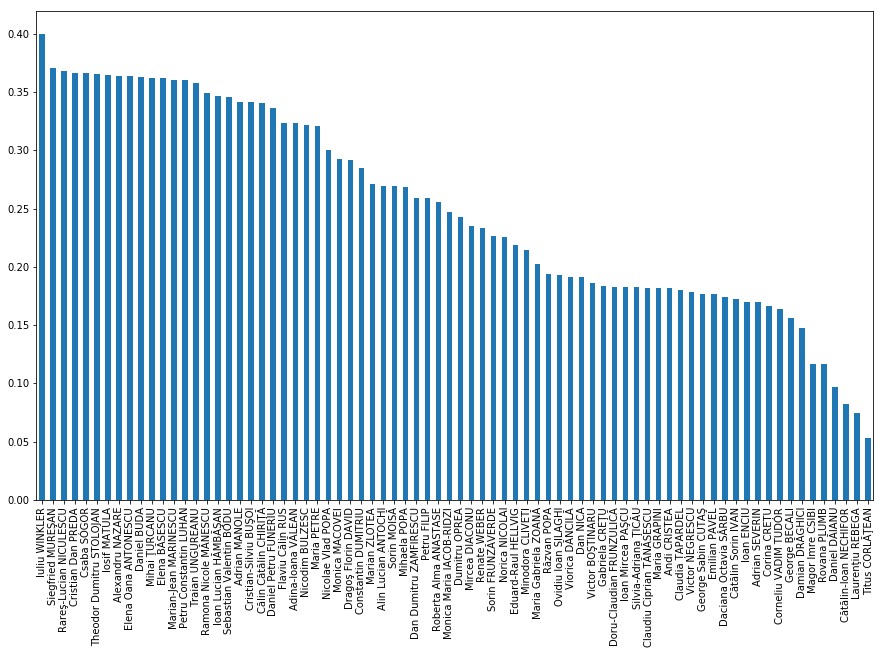

In [250]:
(pd.DataFrame(ro_allegiance_matrix_people_by_people['Iuliu WINKLER']).T['Same_perc']-0.6).\
    sort_values(ascending=False).plot(kind='bar',figsize=(15,9))

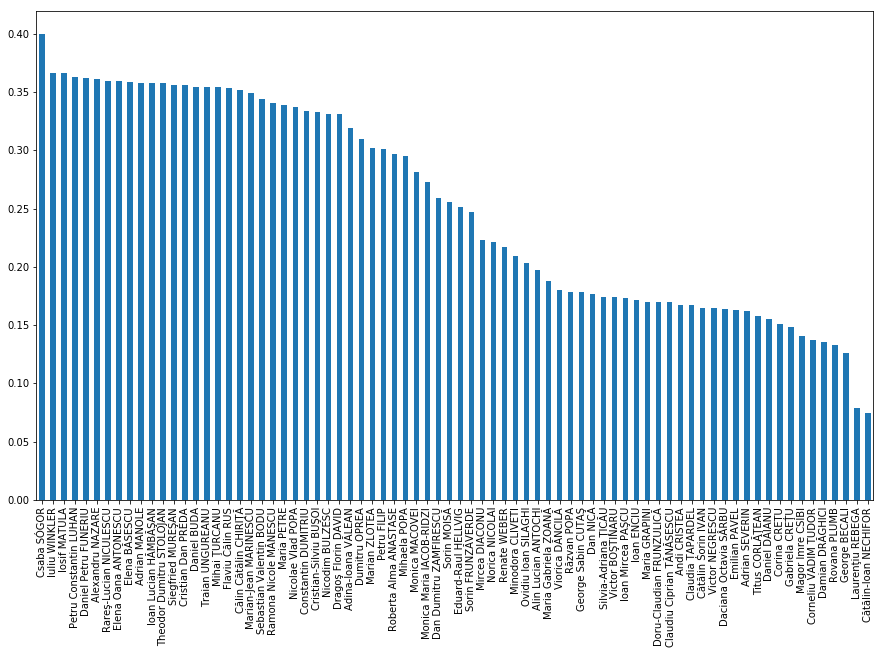

In [251]:
(pd.DataFrame(ro_allegiance_matrix_people_by_people['Csaba SÓGOR']).T['Same_perc']-0.6).\
    sort_values(ascending=False).plot(kind='bar',figsize=(15,9))

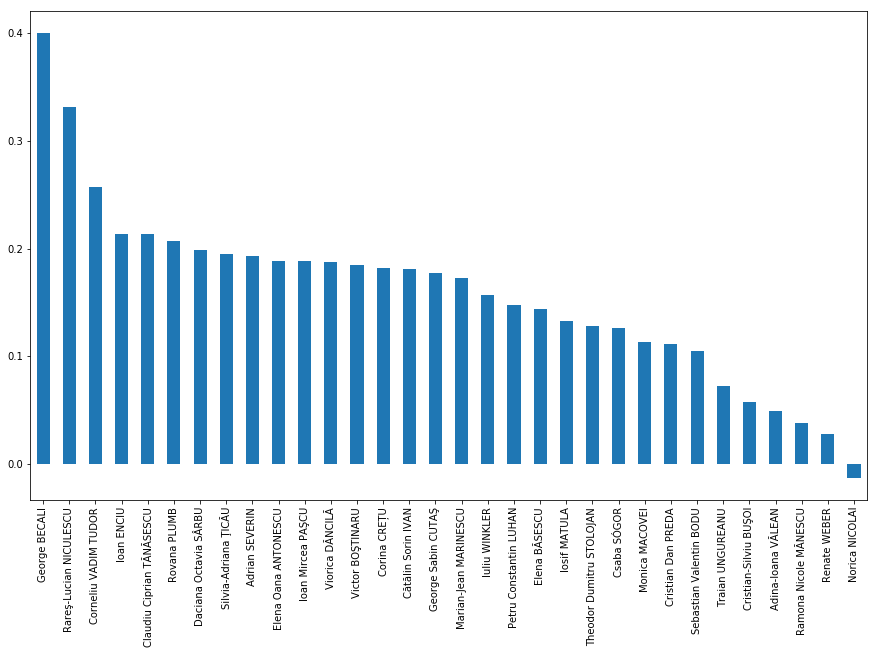

In [252]:
(pd.DataFrame(ro_allegiance_matrix_people_by_people['George BECALI']).T['Same_perc']-0.6).\
    sort_values(ascending=False).plot(kind='bar',figsize=(15,9))

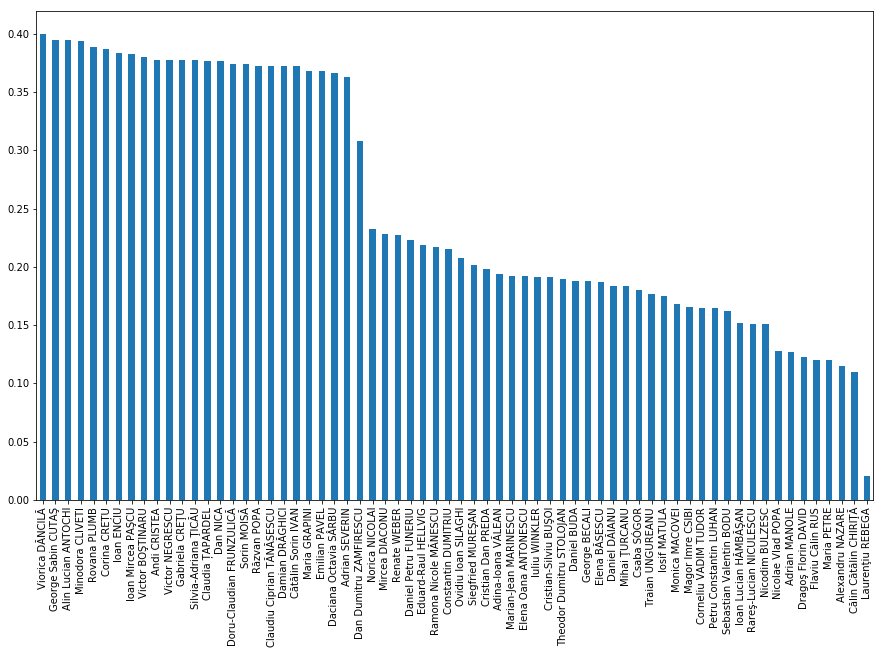

In [253]:
(pd.DataFrame(ro_allegiance_matrix_people_by_people['Viorica DĂNCILĂ']).T['Same_perc']-0.6).\
    sort_values(ascending=False).plot(kind='bar',figsize=(15,9))

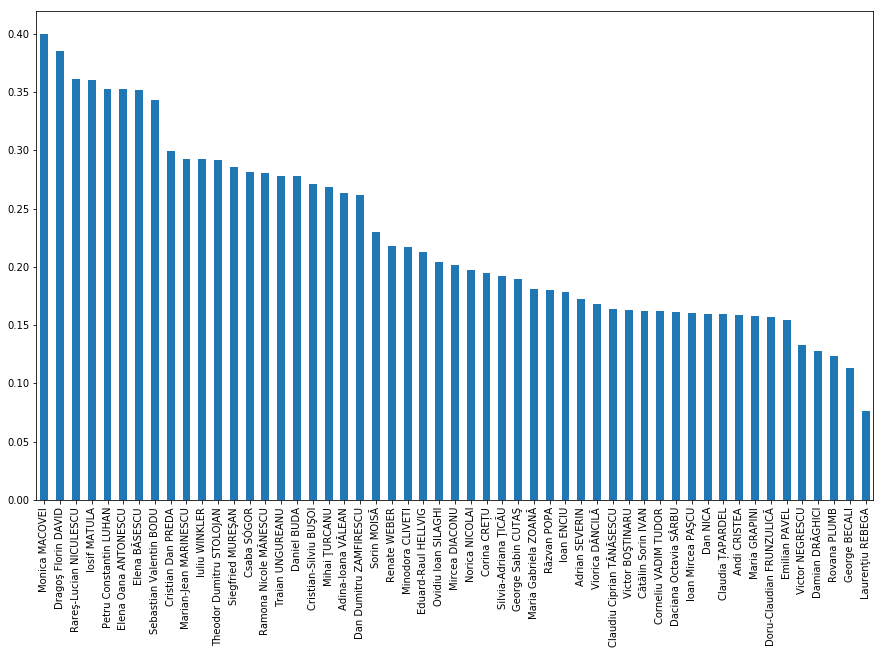

In [254]:
(pd.DataFrame(ro_allegiance_matrix_people_by_people['Monica MACOVEI']).T['Same_perc']-0.6).\
    sort_values(ascending=False).plot(kind='bar',figsize=(15,9))

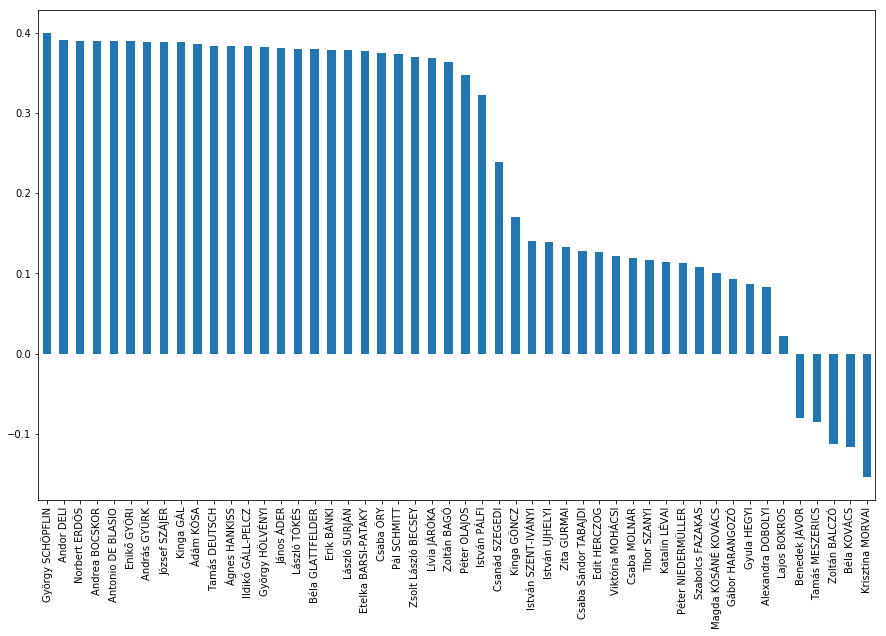

In [255]:
(pd.DataFrame(hu_allegiance_matrix_people_by_people['György SCHÖPFLIN']).T['Same_perc']-0.6).\
    sort_values(ascending=False).plot(kind='bar',figsize=(15,9))

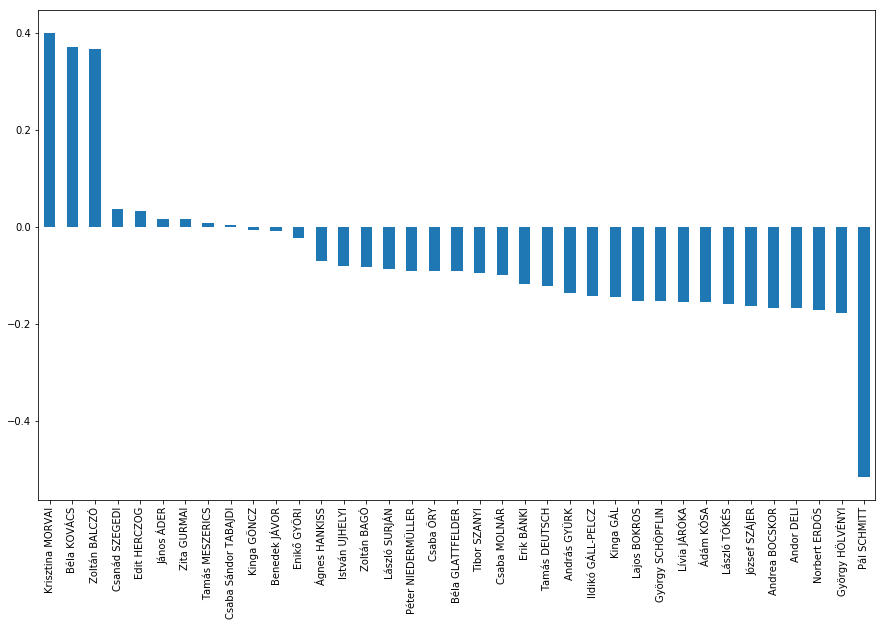

In [256]:
(pd.DataFrame(hu_allegiance_matrix_people_by_people['Krisztina MORVAI']).T['Same_perc']-0.6).\
    sort_values(ascending=False).plot(kind='bar',figsize=(15,9))

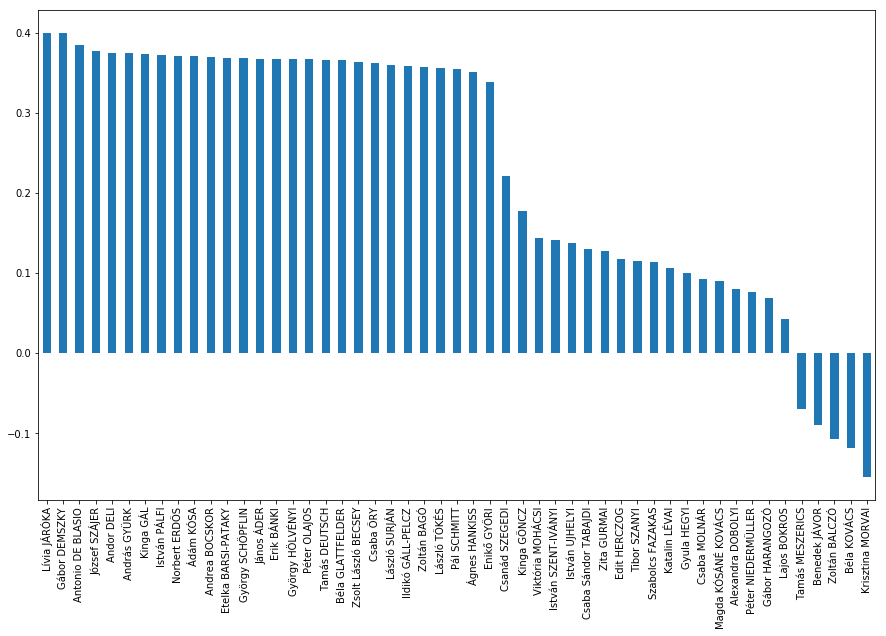

In [257]:
(pd.DataFrame(hu_allegiance_matrix_people_by_people['Lívia JÁRÓKA']).T['Same_perc']-0.6).\
    sort_values(ascending=False).plot(kind='bar',figsize=(15,9))

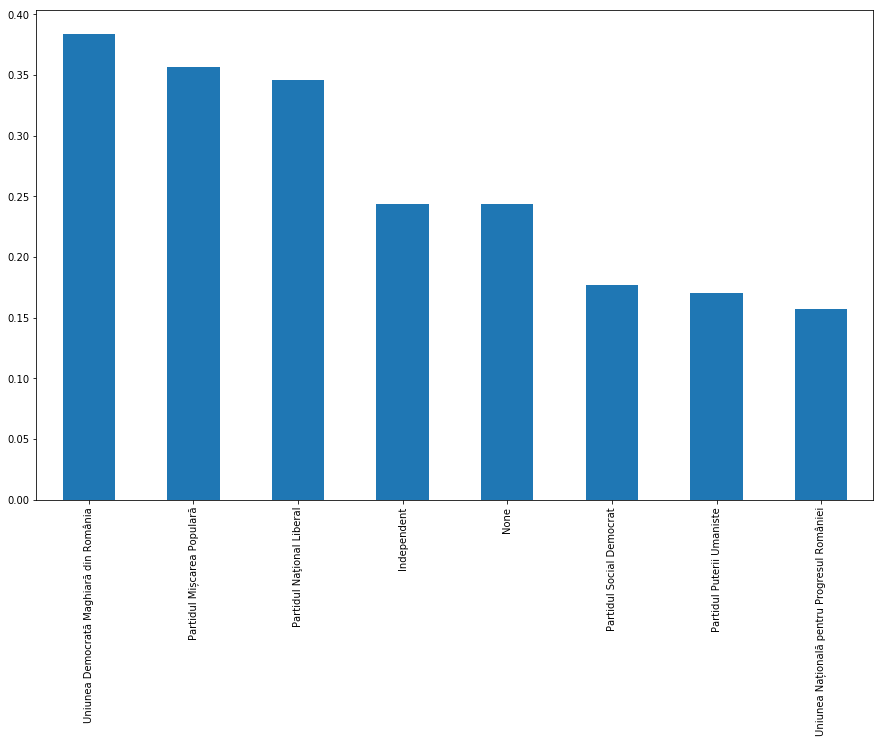

In [258]:
(pd.DataFrame(ro_allegiance_matrix_people_by_party['Csaba SÓGOR']).T['Same_perc']-0.6).\
    sort_values(ascending=False).plot(kind='bar',figsize=(15,9))

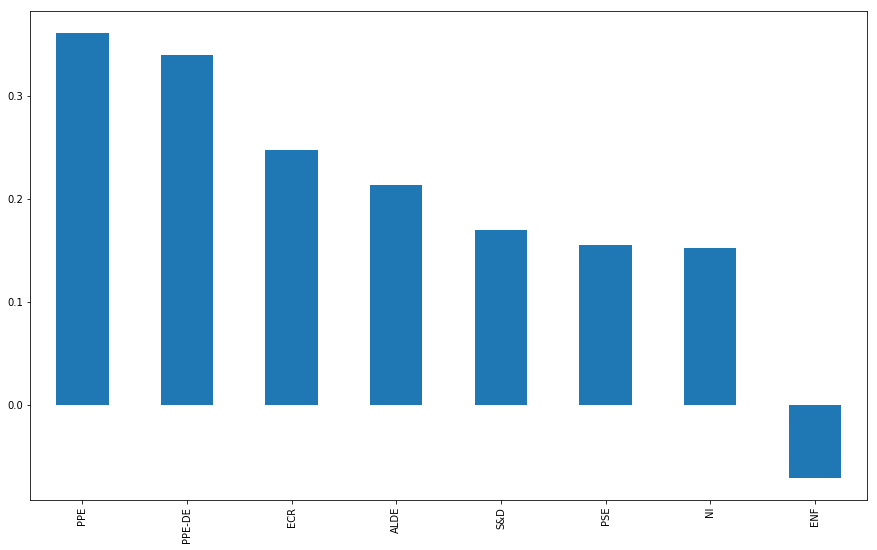

In [259]:
(pd.DataFrame(ro_allegiance_matrix_people_by_group['Csaba SÓGOR']).T['Same_perc']-0.6).\
    sort_values(ascending=False).plot(kind='bar',figsize=(15,9))

In [260]:
ro_allegiance_matrix_party_by_people=get_allegiance_matrix('party',ro_vt,ro_allegiance_people)
hu_allegiance_matrix_party_by_people=get_allegiance_matrix('party',hu_vt,hu_allegiance_people)
ro_allegiance_matrix_party_by_group=get_allegiance_matrix('party',ro_vt,ro_allegiance_group)
hu_allegiance_matrix_party_by_group=get_allegiance_matrix('party',hu_vt,hu_allegiance_group)
ro_allegiance_matrix_party_by_party=get_allegiance_matrix('party',ro_vt,ro_allegiance_party)
hu_allegiance_matrix_party_by_party=get_allegiance_matrix('party',hu_vt,hu_allegiance_party)

In [261]:
ro_allegiance_matrix_group_by_people=get_allegiance_matrix('group',ro_vt,ro_allegiance_people)
hu_allegiance_matrix_group_by_people=get_allegiance_matrix('group',hu_vt,hu_allegiance_people)
ro_allegiance_matrix_group_by_group=get_allegiance_matrix('group',ro_vt,ro_allegiance_group)
hu_allegiance_matrix_group_by_group=get_allegiance_matrix('group',hu_vt,hu_allegiance_group)
ro_allegiance_matrix_group_by_party=get_allegiance_matrix('group',ro_vt,ro_allegiance_party)
hu_allegiance_matrix_group_by_party=get_allegiance_matrix('group',hu_vt,hu_allegiance_party)

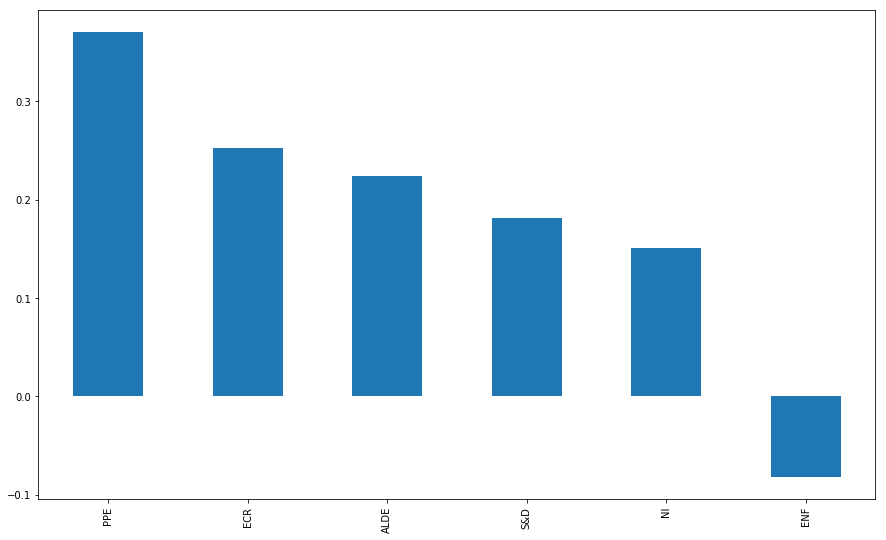

In [262]:
(pd.DataFrame(ro_allegiance_matrix_group_by_group['PPE']).T['Same_perc']-0.6).\
    sort_values(ascending=False).plot(kind='bar',figsize=(15,9))

In [263]:
ro_allegiance_matrix_party_by_party.keys()

dict_keys(['Partidul Naţional Liberal', 'Independent', 'Partidul Mișcarea Populară', 'Uniunea Democrată Maghiară din România', 'Partidul Social Democrat', 'Uniunea Națională pentru Progresul României', 'Partidul Puterii Umaniste', 'None'])

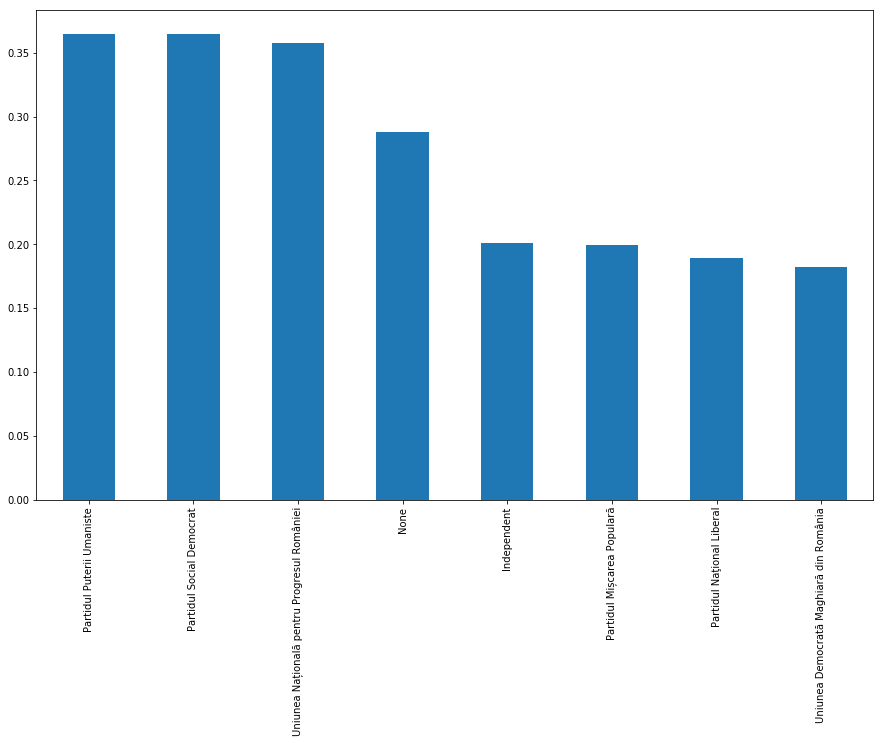

In [267]:
(pd.DataFrame(ro_allegiance_matrix_party_by_party['Partidul Social Democrat']).T['Same_perc']-0.6).\
    sort_values(ascending=False).plot(kind='bar',figsize=(15,9))

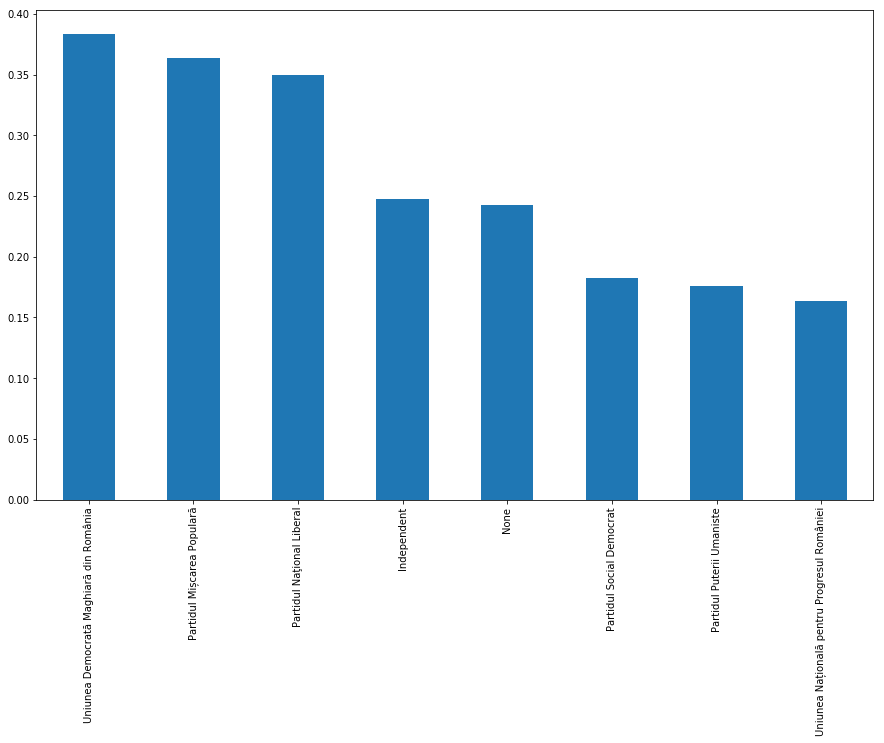

In [264]:
(pd.DataFrame(ro_allegiance_matrix_party_by_party['Uniunea Democrată Maghiară din România']).T['Same_perc']-0.6).\
    sort_values(ascending=False).plot(kind='bar',figsize=(15,9))

In [265]:
hu_allegiance_matrix_party_by_party.keys()

dict_keys(['Jobbik Magyarországért Mozgalom', 'Magyar Szocialista Párt', 'Fidesz-Magyar Polgári Szövetség-Kereszténydemokrata Néppárt', 'Kereszténydemokrata Néppárt', 'Demokratikus Koalíció', 'Együtt 2014 - Párbeszéd Magyarországért', 'None', 'Lehet Más A Politika'])

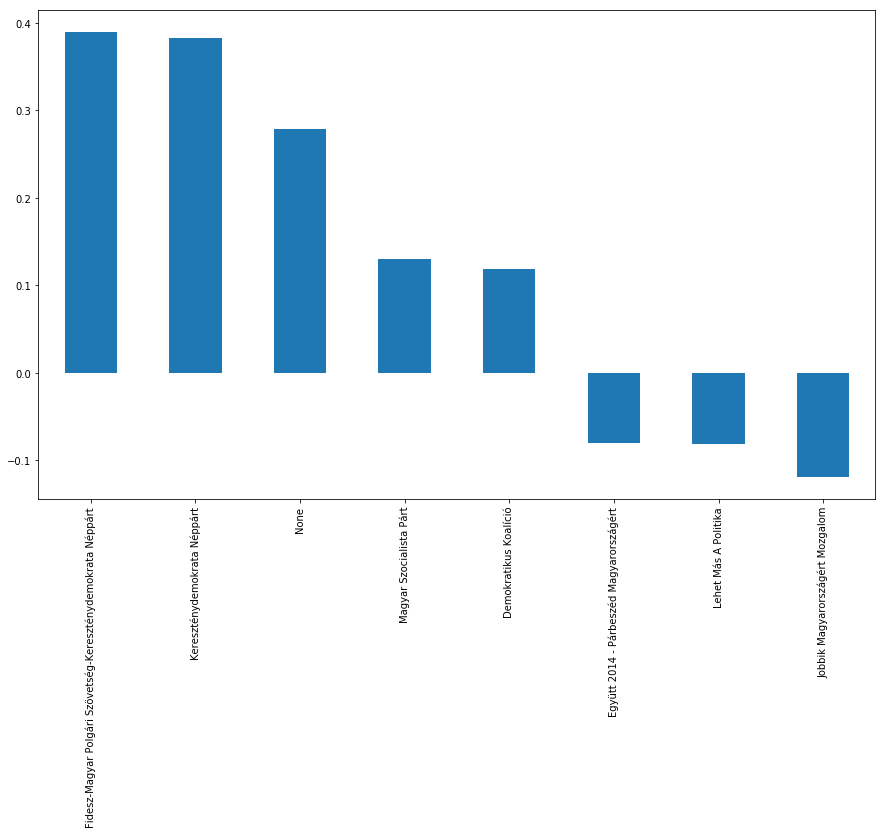

In [266]:
(pd.DataFrame(hu_allegiance_matrix_party_by_party['Fidesz-Magyar Polgári Szövetség-Kereszténydemokrata Néppárt']).T['Same_perc']-0.6).\
    sort_values(ascending=False).plot(kind='bar',figsize=(15,9))

In [270]:
from scipy.cluster.hierarchy import dendrogram, linkage  
import numpy as np

In [325]:
def dict_2_matrix(matrix,key):
    labels=sorted(matrix)
    #extend to square matrix
    inner_keys=matrix[sorted(matrix)[0]]
    inner_keys=sorted(inner_keys[sorted(inner_keys)[0]])
    for name1 in  labels:
        for name2 in labels:
            if name2 not in matrix[name1]:
                matrix[name1][name2]={i:0 for i in inner_keys}
    return np.array([[matrix[name1][name2][key] for name2 in sorted(matrix[name1])] for name1 in labels]),labels

In [358]:
def dendro(matrix,key='Same_perc'):
    X,labelList=dict_2_matrix(matrix,key)
    linked = linkage(X, 'ward')
    plt.figure(figsize=(14, 7))  
    dendrogram(linked,  
                orientation='top',
                labels=labelList,
                distance_sort='descending',
                show_leaf_counts=True)
    ax=plt.gca()
    plt.setp(ax.get_xticklabels(), rotation=90, fontsize=9)
    plt.show()  

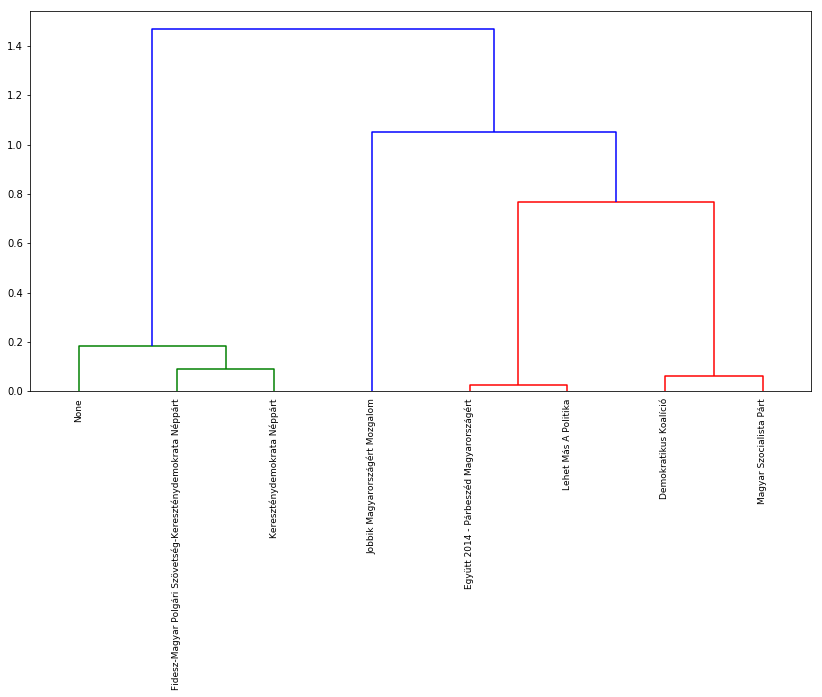

In [359]:
dendro(hu_allegiance_matrix_party_by_party)

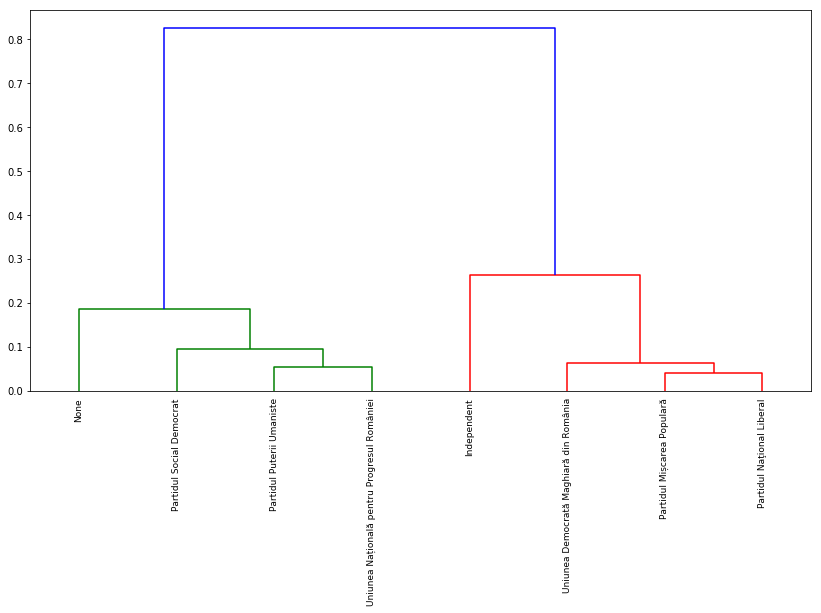

In [360]:
dendro(ro_allegiance_matrix_party_by_party)

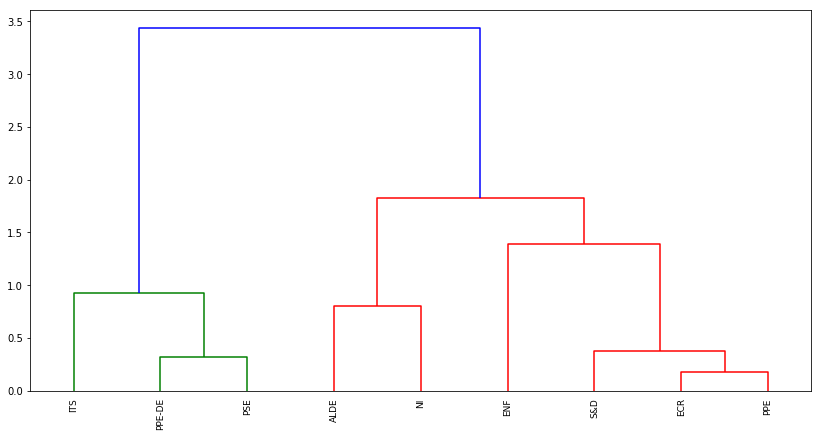

In [361]:
dendro(ro_allegiance_matrix_group_by_group)

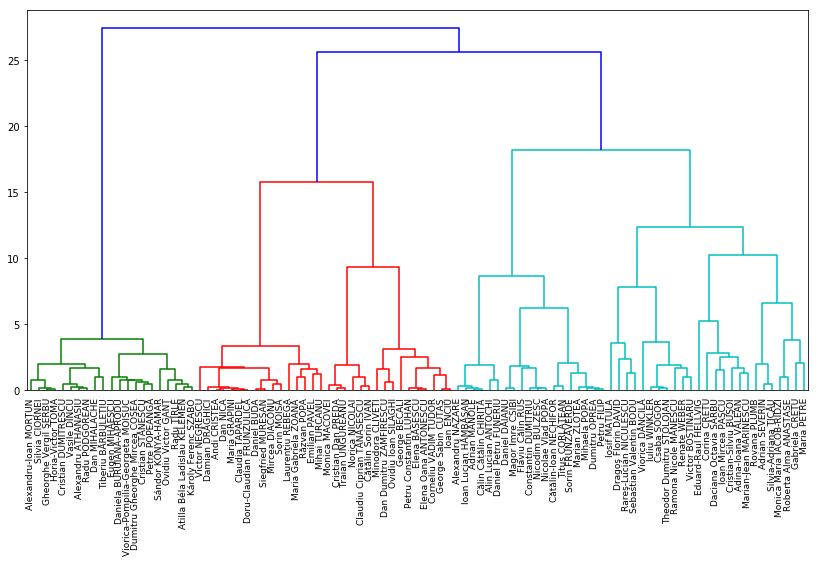

In [362]:
dendro(ro_allegiance_matrix_people_by_people)

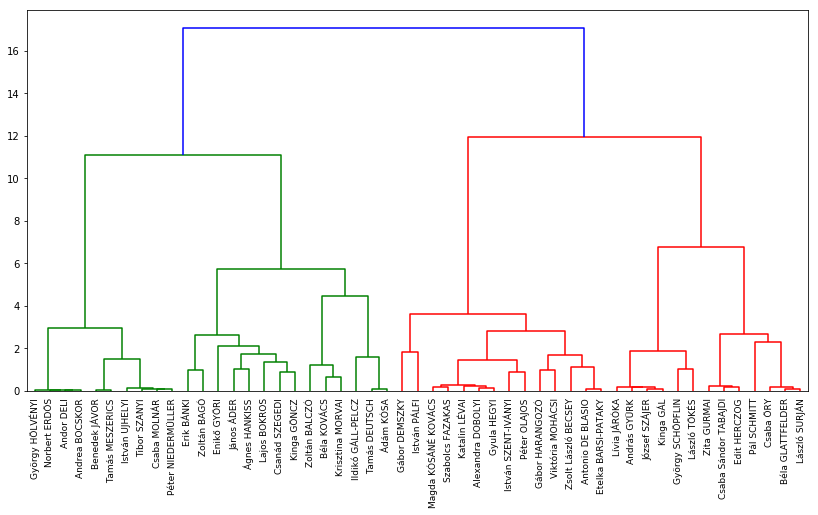

In [363]:
dendro(hu_allegiance_matrix_people_by_people)

multicountry

In [367]:
ro_allegiance_matrix_party_by_party.update(hu_allegiance_matrix_party_by_party)

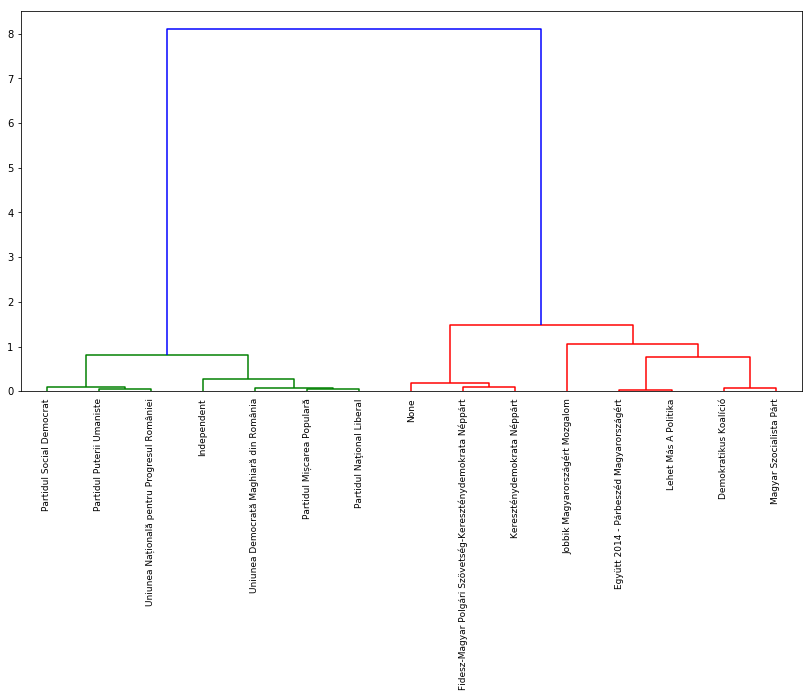

In [368]:
dendro(ro_allegiance_matrix_party_by_party)

Matrix 2 adjacency list

In [370]:
matrix,labels=dict_2_matrix(hu_allegiance_matrix_party_by_party,'Same_perc')

In [371]:
from scipy import sparse

In [387]:
row, col = np.where(matrix)
coo = np.rec.fromarrays([row, col, matrix[row, col]], names='row col value'.split())
#coo = coo.tolist()

In [388]:
row

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5,
       5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7],
      dtype=int64)

In [380]:
[[labels[i[0]],labels[i[1]],i[2]] for i in coo if [labels[i[0]],labels[i[1]]]

IndexError: list index out of range